In [1]:
import json
import emoji
import sys
import re
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [2]:
embedding_dim = 200
max_length = 120
filters = 32
kernel_size = 3
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [3]:
emoji_list = emoji.UNICODE_EMOJI.keys()

In [4]:
with open('racism.json', 'r') as file:
    data_racism = pd.read_json(file,lines=True)
with open('neither.json', 'r') as file:
    data_neither = pd.read_json(file,lines=True)
with open('sexism.json', 'r') as file:
    data_sexism = pd.read_json(file,lines=True)

In [5]:
labels_read = []
text_read = []
labels_read = list(data_racism['Annotation'])
text_read = list(data_racism['text'])
labels_read.extend(list(data_neither['Annotation']))
labels_read.extend(list(data_sexism['Annotation']))
text_read.extend(list(data_neither['text']))
text_read.extend(list(data_sexism['text']))

print(len(text_read))

16907


In [6]:
labels = list()
texts = list()
i = 0
for i in range(0,len(text_read)):
    labels.append(labels_read[i])
    texts.append(text_read[i])
# print(type(text_read[i]))
print(len(texts))
print(len(labels))

16907
16907


In [7]:
FLAGS = re.MULTILINE | re.DOTALL

def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps>"


def preprocess(text):
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)
    
    text = text.replace("#","<hashtag> ")
    
    no_punct = ''
    for char in text:
        if char not in emoji_list:
            no_punct = no_punct + char
        else:
            no_punct = no_punct + '<' + emoji.demojize(char) + '> '
    text = no_punct 
    
    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
    text = re_sub(r"@\w+", " <user> ")
    text = re_sub(r"/"," / ")
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")

    text = re_sub(r"([A-Z]){2,}", allcaps)
    
    punctuations = '''!()-[]{};:'"\,./?@#$%^&*_~0123456789'''
    
    no_punct = ''
    for char in text:
        if char not in punctuations:
            no_punct = no_punct + char
    text = no_punct

    return text.lower()

In [8]:
for i in range(0, len(texts)):
    texts[i] = preprocess(texts[i])

In [9]:
print(set(labels))

{'none', 'sexism', 'racism'}


In [10]:
train_tweets, validation_tweets, train_labels, validation_labels = train_test_split(texts, labels, test_size=0.2)
print(len(train_tweets))
print(len(train_labels))
print(len(validation_tweets))
print(len(validation_labels))
print(train_labels[:10])

13525
13525
3382
3382
['sexism', 'none', 'sexism', 'none', 'none', 'none', 'none', 'none', 'racism', 'none']


In [11]:
vocab_size=0
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(train_tweets)
word_index = tokenizer.word_index
vocab_size=len(word_index)

train_sequences = tokenizer.texts_to_sequences(train_tweets)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)

print(len(word_index))
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

14998
10
120
9
120


In [12]:
validation_sequences = tokenizer.texts_to_sequences(validation_tweets)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

3382
(3382, 120)


In [13]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

padded_validation_label_seq = pad_sequences(validation_label_seq, padding=padding_type, maxlen=1, truncating=trunc_type)
train_lables_padded = pad_sequences(training_label_seq, padding=padding_type, maxlen=1, truncating=trunc_type)

category_word_index = label_tokenizer.word_index

In [14]:
print(train_padded.shape)
print(train_lables_padded.shape)

(13525, 120)
(13525, 1)


In [15]:
embeddings_index = {};
with open('glove.6B.200d.txt', errors='ignore') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:])#, dtype='float32')
        embeddings_index[word] = coefs

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [16]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length = max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation = 'sigmoid'),
    tf.keras.layers.Dense(4, activation = 'softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.RMSprop(), metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 200)          2999800   
_________________________________________________________________
bidirectional (Bidirectional (None, 120, 128)          135680    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 68        
Total params: 3,177,804
Trainable params: 3,177,804
Non-trainable params: 0
______________________________________________

In [18]:
num_epochs = 10
history = model.fit(train_padded, train_lables_padded, epochs = num_epochs, validation_data=(validation_padded, padded_validation_label_seq), verbose = 2)

Train on 13525 samples, validate on 3382 samples
Epoch 1/10
13525/13525 - 117s - loss: 0.7721 - acc: 0.7018 - val_loss: 0.6769 - val_acc: 0.7102
Epoch 2/10
13525/13525 - 100s - loss: 0.5169 - acc: 0.8087 - val_loss: 0.4884 - val_acc: 0.8164
Epoch 3/10
13525/13525 - 179s - loss: 0.3922 - acc: 0.8588 - val_loss: 0.4268 - val_acc: 0.8341
Epoch 4/10
13525/13525 - 181s - loss: 0.3331 - acc: 0.8762 - val_loss: 0.4408 - val_acc: 0.8329
Epoch 5/10
13525/13525 - 182s - loss: 0.2910 - acc: 0.8951 - val_loss: 0.4640 - val_acc: 0.8321
Epoch 6/10
13525/13525 - 181s - loss: 0.2569 - acc: 0.9093 - val_loss: 0.4884 - val_acc: 0.8247
Epoch 7/10
13525/13525 - 183s - loss: 0.2329 - acc: 0.9198 - val_loss: 0.4742 - val_acc: 0.8244
Epoch 8/10
13525/13525 - 185s - loss: 0.2054 - acc: 0.9292 - val_loss: 0.4947 - val_acc: 0.8087
Epoch 9/10
13525/13525 - 184s - loss: 0.1836 - acc: 0.9375 - val_loss: 0.5306 - val_acc: 0.8060
Epoch 10/10
13525/13525 - 184s - loss: 0.1661 - acc: 0.9447 - val_loss: 0.5590 - val_ac

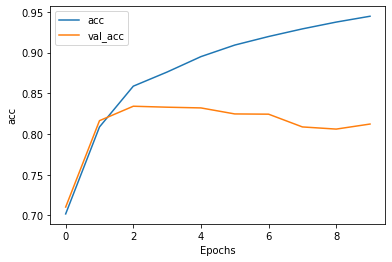

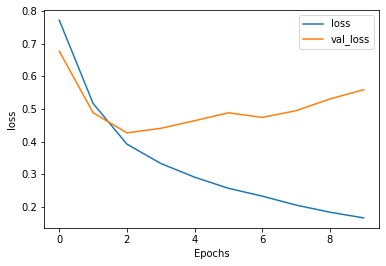

In [19]:
plot_graphs(history, "acc")
plot_graphs(history, "loss")